# Rectified Diffusion

Rectified Diffusion: Straightness Is Not Your Need in Rectified Flow, Wang et al., 2024. [[arXiv:2410.07303](https://arxiv.org/abs/2410.07303)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

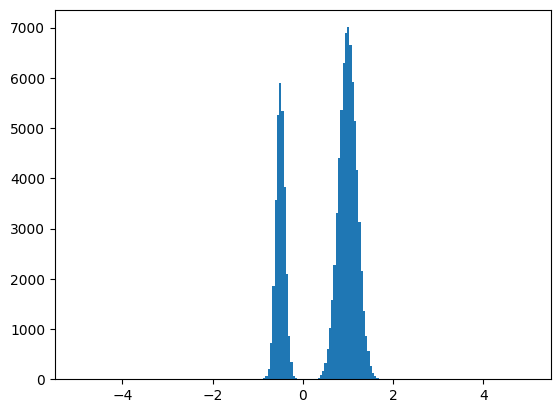

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D

mixture = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.]), torch.tensor([0.1, 0.2])),
)
# target distribution
X = mixture.sample((100000, 1))

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Score Model

Define MLP backbone and score model first.

In [2]:
import torch
import torch.nn as nn

from flowmodels import DDPM, DDIMScheduler


class Backbone(nn.Module):
    def __init__(self, dim: int = 1, layers: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            *[
                submodule
                for _ in range(layers)
                for submodule in (nn.ReLU(), nn.Linear(64, 64))
            ],
            nn.ReLU(),
            nn.Linear(64, dim)
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.net.forward(torch.cat([x_t, t[:, None].to(x_t)], dim=-1))

model = DDPM(Backbone(), DDIMScheduler())
model

DDPM(
  (noise_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train Score Model

Train the score model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

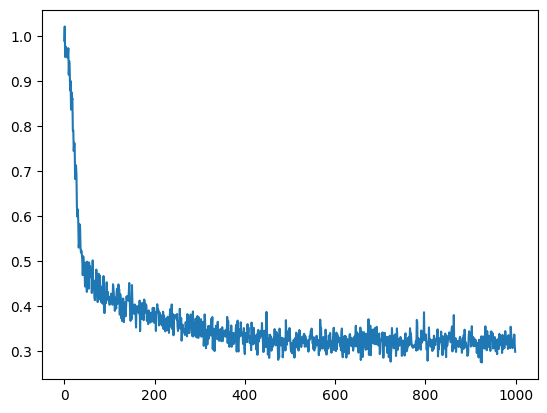

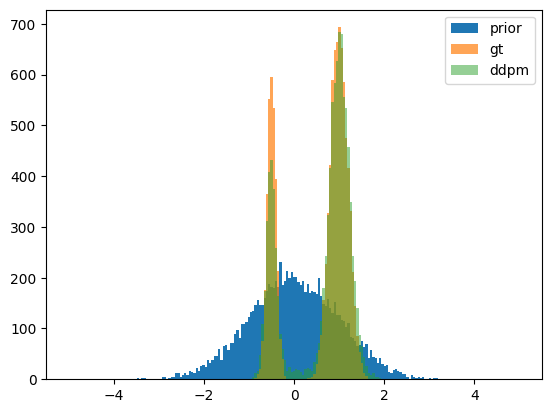

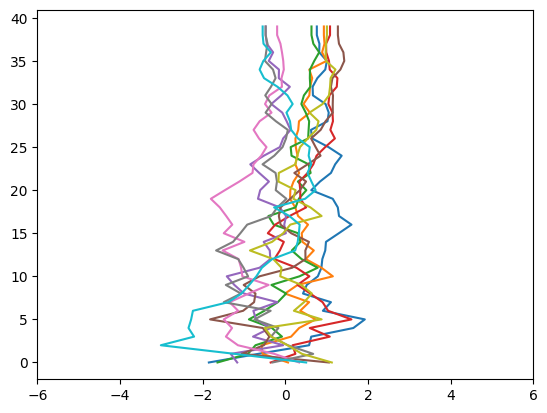

In [3]:
import torch
from tqdm.auto import tqdm

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        loss = model.loss(sample=X[torch.randint(0, len(X), (BATCH_SIZE,))])
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)

# plot histogram
n = 10000
sample = torch.randn(n, X.shape[-1])
x_t, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False))

plt.figure()
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="ddpm", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
x_t, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None])
plt.figure()
for i in range(10):
    plt.plot(torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]), range(len(x_ts)))
    plt.xticks(_xticks)

## 4. Distill to Rectified Diffusion

Distill the knowledge of the pretrained score model to Rectified Diffusion

In [4]:
import copy

import torch.nn as nn

from flowmodels.rd import RectificationSupports


class _Wrapper(nn.Module, RectificationSupports):
    def __init__(self, ddpm: DDPM):
        super().__init__()
        self.ddpm = copy.deepcopy(ddpm)
        # overwriting
        self.scheduler = self.ddpm.scheduler
        self.score = self.ddpm.score
        self.loss = self.ddpm.loss

    def forward(self, x_t: torch.Tensor, t: torch.Tensor):
        # convert t in range[0, 1] to range[0, T]
        return self.ddpm.forward(x_t, (t * self.scheduler.T).long())
    
    def noise(self, x_0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor | None = None):
        # convert t in range[1/T, 1] to range[1, T]        
        return self.ddpm.noise(x_0, (t * self.scheduler.T).long(), eps)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

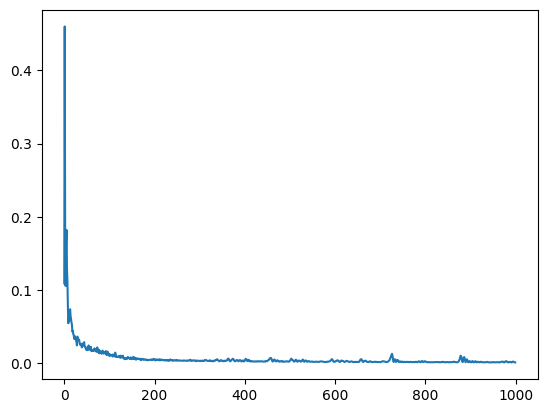

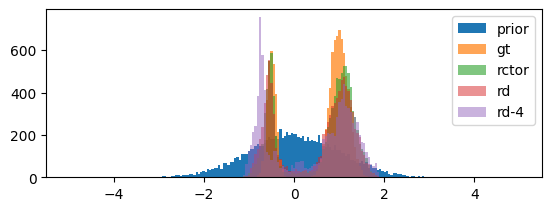

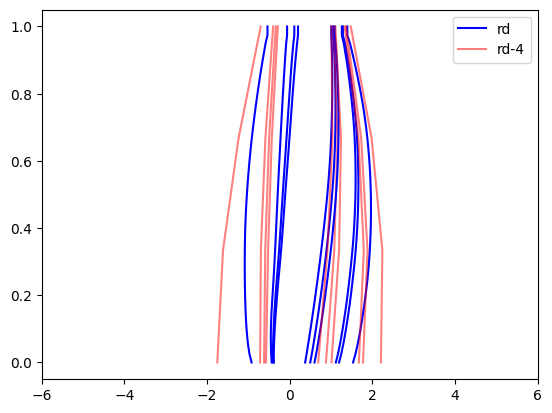

In [5]:
from flowmodels import RecitifedDiffusion

# define rectified diffusion
rd = RecitifedDiffusion(_Wrapper(model))

# distillation
LR = 0.001
SAMPLE_STEPS = 100
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])
optim = torch.optim.Adam(rd.parameters(), LR)
losses, rctor = rd.rectify(
    optim,
    prior,
    TRAIN_STEPS,
    BATCH_SIZE,
    verbose=lambda r: tqdm(r, leave=False),
)
plt.plot(losses)

# plot histogram
with torch.inference_mode():
    # T-sample via consistency sampling(= can be viewed as DDIM method)
    x_t, x_ts = rd.sample(sample)
    # 4-sample
    x_4, x_4s = rd.sample(sample, steps=4)
plt.figure()
plt.subplot(2, 1, 1)
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(rctor[:n], bins=np.linspace(-5, 5, 200), label="rctor", alpha=0.6)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="rd", alpha=0.5)
plt.hist(x_4.view(-1), bins=np.linspace(-5, 5, 200), label="rd-4", alpha=0.5)

plt.legend()
xticks, _ = plt.xticks()

# plot trajectory
plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]),
        np.linspace(0, 1, len(x_ts)),
        'b',
        **({} if i > 0 else {"label": "rd"})  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_4s]),
        np.linspace(0, 1, len(x_4s)),
        'r',
        alpha=0.5,
        **({} if i > 0 else {"label": "rd-4"})
    )
    plt.xticks(xticks)
plt.legend()

### Distillation

Distill the model for single-step generation

  0%|          | 0/1000 [00:00<?, ?it/s]

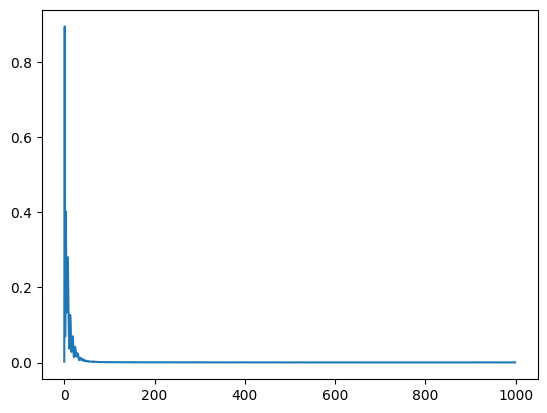

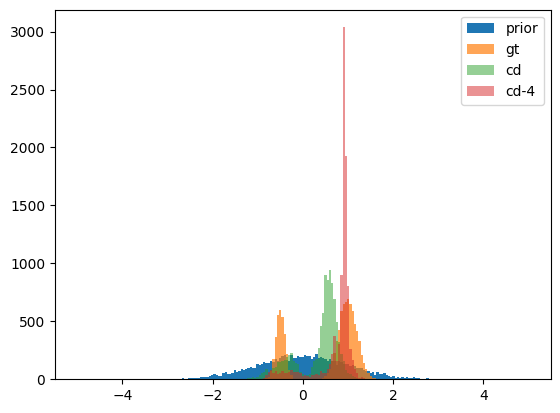

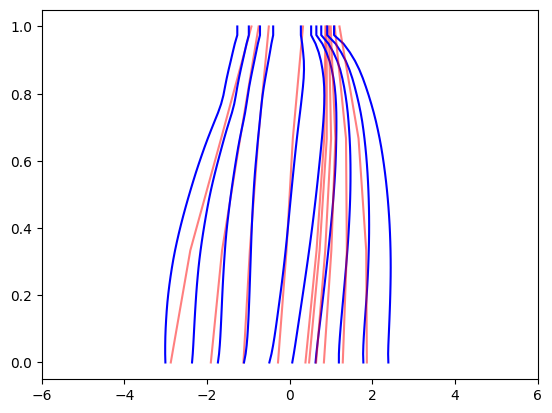

In [6]:
# REFLOW
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

n = 10000
prior = torch.randn(n, X.shape[-1])

distill = copy.deepcopy(rd)
optim = torch.optim.Adam(distill.parameters(), LR)
losses = distill.consistency_distillation(
    optim,
    prior,
    training_steps=TRAIN_STEPS,
    batch_size=BATCH_SIZE,
    verbose=lambda x: tqdm(x, leave=False),
)

plt.plot(losses)

# plot the trajectory
plt.figure()

n = 10000
sample = torch.randn(n, X.shape[-1])

with torch.inference_mode():
    x_t, x_ts = distill.sample(sample)
    x_4, x_4s = distill.sample(sample, steps=4)
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="cd", alpha=0.5)
plt.hist(x_4.view(-1), bins=np.linspace(-5, 5, 200), label="cd-4", alpha=0.5)
plt.legend()

plt.figure()
n = 200
with torch.inference_mode():
    x_t, x_ts = distill.sample(torch.linspace(-3, 3, n)[:, None])
    x_4, x_4s = distill.sample(torch.linspace(-3, 3, n)[:, None], steps=4)
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]),
        np.linspace(0, 1, len(x_ts)),
        'b',
        **({} if i > 0 else {"label": "cd"})  # labeling on first plot only
    )
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_4s]),
        np.linspace(0, 1, len(x_4s)),
        'r',
        alpha=0.5,
        **({} if i > 0 else {"label": "cd-4"})
    )
    plt.xticks(xticks)